This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2025.1_tutorials/wallaroo-run-anywhere/pipeline-edge-publish/edge-observability-cv).

## Computer Vision for Object Detection for Edge Deployments in Retail

The following tutorial demonstrates using Wallaroo for observability of edge deployments of computer vision models.

## Introduction

This tutorial focuses on the resnet50 computer vision model. By default, this provides the following outputs from receiving an image converted to tensor values:

* `boxes`: The bounding boxes for detected objects.
* `classes`: The class of the detected object (bottle, coat, person, etc).
* `confidences`: The confidence the model has that the detected model is the class.

For this demonstration, the model is modified with [Wallaroo Bring Your Own Predict (BYOP)](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-arbitrary-python/) to add two additional fields:

* `avg_px_intensity`: the average pixel intensity checks the input to determine the average value of the Red/Green/Blue pixel values.  This is used as a benchmark to determine if the two images are significantly different.  For example, an all white photo would have an `avg_px_intensity` of `1`, while an all blank photo would have a value of `0`.
* `avg_confidence`: The average confidence of all detected objects.

This demonstration will use `avg_confidence` to demonstrate observability in our edge deployed computer vision model.

## Prerequisites

* A Wallaroo Ops instance 2023.4 and above with [edge deployment enabled]([Edge Deployment Registry Guide](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-edge-deployment/)).
* An x64 edge device with Docker installed, recommended with at least 8 cores.

In order for the wallaroo tutorial notebooks to run properly, the videos directory must contain these models in the models directory.

To download the Wallaroo Computer Vision models, use the following link:

https://storage.googleapis.com/wallaroo-public-data/cv-demo-models/cv-retail-models.zip

Unzip the contents into the directory `models`.

The following models are required to run the tutorial:

```python
onnx==1.12.0
onnxruntime==1.12.1
torchvision
torch
matplotlib==3.5.0
opencv-python
imutils
pytz
ipywidgets
```

To run this tutorial outside of a Wallaroo Ops center, the [Wallaroo SDK](https://pypi.org/project/wallaroo/) is available and is installed via `pip` with:

`pip install wallaroo==2024.4`

## References

* [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/)

## Steps

### Import Libraries

The following libraries are used to execute this tutorial.  The `utils.py` provides additional helper methods for rendering the images into tensor fields and other useful tasks.

In [16]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from IPython.display import display
from IPython.display import Image
import pandas as pd
import json
import datetime
import time
import cv2
import matplotlib.pyplot as plt
import string
import random
import pyarrow as pa
import sys
import asyncio
import numpy as np


import utils
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import datetime

# api based inference request
import requests

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

The option `request_timeout` provides additional time for the Wallaroo model upload process to complete.

In [2]:
wl = wallaroo.Client(request_timeout=600)

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace names must be unique.  The following helper function will either create a new workspace, or retrieve an existing one with the same name.  Verify that a pre-existing workspace has been shared with the targeted user.

Set the variables `workspace_name` to ensure a unique workspace name if required.

The workspace will then be set as the Current Workspace.  Model uploads and pipeline creation through the SDK are set in the current workspace.

* References
  * [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)

In [3]:
workspace_name = "cv-retail-edge-observability"
model_name = "resnet-with-intensity"
model_file_name = "./models/model-with-pixel-intensity.zip"
pipeline_name = "retail-inv-tracker-edge-obs"

workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)
wl.set_current_workspace(workspace)

{'name': 'cv-retail-edge-observability', 'id': 8, 'archived': False, 'created_by': 'cc3619bb-2cec-4a44-9333-55a0dc6b3997', 'created_at': '2024-01-10T17:37:38.659309+00:00', 'models': [], 'pipelines': []}

### Upload Model

The model is uploaded as a BYOP model, where the model, Python script and other artifacts are included in a .zip file.  This requires the input and output schemas for the model specified in Apache Arrow Schema format.

* References
  * [Wallaroo SDK Essentials Guide: Model Uploads and Registrations: Custom Model](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-arbitrary-python/)

In [4]:
input_schema = pa.schema([
    pa.field('tensor', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(), # images are normalized
                list_size=640
            ),
            list_size=480
        ),
        list_size=3
    )),
])

output_schema = pa.schema([
    pa.field('boxes', pa.list_(pa.list_(pa.float32(), list_size=4))),
    pa.field('classes', pa.list_(pa.int64())),
    pa.field('confidences', pa.list_(pa.float32())),
    pa.field('avg_px_intensity', pa.list_(pa.float32())),
    pa.field('avg_confidence', pa.list_(pa.float32())),
])


model = wl.upload_model(model_name, 
                        model_file_name, 
                        framework=Framework.CUSTOM,
                        input_schema=input_schema, 
                        output_schema=output_schema)

Waiting for model loading - this will take up to 10.0min.
Model is pending loading to a container runtime......
Model is attempting loading to a container runtime.............successful

Ready


### Deploy Pipeline

Next we configure the hardware we want to use for deployment. If we plan on eventually deploying to edge, this is a good way to simulate edge hardware conditions.  The BYOP model is deployed as a Wallaroo Containerized Runtime, so the hardware allocation is performed through the `sidekick` options.

* References
  * [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-deployment-config/)

In [5]:
deployment_config = wallaroo.DeploymentConfigBuilder() \
    .replica_count(1) \
    .cpus(1) \
    .memory("2Gi") \
    .sidekick_cpus(model, 1) \
    .sidekick_memory(model, '6Gi') \
    .build()

We create the pipeline with the `wallaroo.client.build_pipeline` method, and assign our model as a model pipeline step.  Once complete, we will deploy the pipeline to allocate resources from the Kuberntes cluster hosting the Wallaroo Ops to the pipeline.

In [6]:
pipeline = wl.build_pipeline(pipeline_name)
pipeline.clear()
pipeline.add_model_step(model)
pipeline.deploy(deployment_config = deployment_config)

name,retail-inv-tracker-edge-obs
created,2024-01-10 17:50:59.035145+00:00
last_updated,2024-01-10 17:50:59.700103+00:00
deployed,True
arch,None
tags,
versions,"d0c2ed1c-3691-49f1-8fc8-e6510e4c39f8, 773099d3-6d64-4a92-b5a7-f614a916965d"
steps,resnet-with-intensity
published,False


## Monitoring for Model Drift

For this example, we want to track the average confidence of object predictions and get alerted if we see a drop in confidence.

We will convert a set of images to pandas DataFrames with the images converted to tensor values.  The first set of images `baseline_images` as well formed images.  The second set `blurred_images` are the same photos intentionally blurred for our observability demonstration.

In [7]:
baseline_images = [
    "./data/images/input/example/dairy_bottles.png",
    "./data/images/input/example/dairy_products.png",
    "./data/images/input/example/product_cheeses.png"
]
   
blurred_images = [
    "./data/images/input/example/blurred-dairy_bottles.png",
    "./data/images/input/example/blurred-dairy_products.png",
    "./data/images/input/example/blurred-product_cheeses.png"
]

baseline_images_list = utils.processImages(baseline_images)
blurred_images_list = utils.processImages(blurred_images)


The Wallaroo SDK is capable of using numpy arrays in a pandas DataFrame for inference requests.  Our demonstration will focus on using API calls for inference requests, so we will flatten the numpy array and use that value for our inference inputs.  The following examples show using a baseline and blurred image for inference requests and the sample outputs.

In [8]:
# baseline image
df_test = pd.DataFrame({'tensor': wallaroo.utils.flatten_np_array_columns(baseline_images_list[0], 'tensor')})

In [9]:
df_test

,tensor
0,"[0.9372549, 0.9529412, 0.9490196, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.9490196, 0.9490196, 0.9529412, 0.9529412, 0.9490196, 0.9607843, 0.96862745, 0.9647059, 0.96862745, 0.9647059, 0.95686275, 0.9607843, 0.9647059, 0.9647059, 0.9607843, 0.9647059, 0.972549, 0.95686275, 0.9607843, 0.91764706, 0.95686275, 0.91764706, 0.8784314, 0.89411765, 0.84313726, 0.8784314, 0.8627451, 0.8509804, 0.9254902, 0.84705883, 0.96862745, 0.89411765, 0.81960785, 0.8509804, 0.92941177, 0.8666667, 0.8784314, 0.8666667, 0.9647059, 0.9764706, 0.98039216, 0.9764706, 0.972549, 0.972549, 0.972549, 0.972549, 0.972549, 0.972549, 0.98039216, 0.89411765, 0.48235294, 0.4627451, 0.43137255, 0.27058825, 0.25882354, 0.29411766, 0.34509805, 0.36862746, 0.4117647, 0.45490196, 0.4862745, 0.5254902, 0.56078434, 0.6039216, 0.64705884, 0.6862745, 0.72156864, 0.74509805, 0.7490196, 0.7882353, 0.8666667, 0.98039216, 0.9882353, 0.96862745, 0.9647059, 0.96862745, 0.972549, 0.9647059, 0.9607843, 0.9607843, 0.9607843, 0.9607843, ...]"


In [10]:
result = pipeline.infer(df_test, 
                        dataset=['time', 'out.avg_confidence','out.avg_px_intensity','out.boxes','out.classes','out.confidences','check_failures','metadata'])
result

time out.avg_confidence out.avg_px_intensity  \
0 2024-01-10 17:53:50.655       [0.35880384]           [0.425382]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [11]:
# example of an inference from a bad photo

df_test = pd.DataFrame({'tensor': wallaroo.utils.flatten_np_array_columns(blurred_images_list[0], 'tensor')})

In [12]:
result = pipeline.infer(df_test, dataset=['time', 'out.avg_confidence','out.avg_px_intensity','out.boxes','out.classes','out.confidences','check_failures','metadata'])
result

,time,out.avg_confidence,out.avg_px_intensity,out.boxes,out.classes,out.confidences,check_failures,metadata.dropped,metadata.elapsed,metadata.last_model,metadata.partition,metadata.pipeline_version
0,2024-01-10 17:53:59.016,[0.29440108],[0.42540666],"[[1.104647, 203.48311, 81.29011, 472.4321], [67.34002, 195.64558, 163.41652, 470.1668], [218.88916, 180.21216, 281.3725, 422.2332], [156.47955, 189.82559, 227.1866, 443.35718], [393.81195, 172.34473, 434.30322, 363.96057], [266.56137, 201.46182, 326.2503, 406.3162], [542.941, 99.440956, 588.42365, 229.33481], [426.12668, 260.50723, 638.6193, 476.10742], [511.26102, 106.84715, 546.8103, 243.0127], [0.0, 68.56848, 482.48538, 472.53766], [347.34027, 0.0, 401.10968, 97.51968], [289.03827, 0.32189485, 347.78888, 93.458755], [91.05826, 183.34473, 207.86084, 469.46518], [613.1202, 102.11072, 639.4794, 228.7474], [369.04257, 177.80518, 419.34775, 371.53873], [512.19727, 92.89032, 548.08636, 239.37686], [458.50125, 115.80958, 485.57538, 236.75961], [571.35834, 102.115395, 620.06, 230.47636], [481.23752, 105.288246, 516.5597, 246.37486], [74.288246, 0.4324219, 162.55719, 80.09118], [566.6188, 102.72982, 623.63257, 226.31448], [14.5338335, 0.0, 410.35077, 100.371155], [67.72321, 186.76591, 144.67079, 272.91965], [171.88432, 1.3620621, 220.8489, 82.6873], [455.16003, 109.83146, 486.36246, 243.25917], [320.3717, 211.61632, 373.62762, 397.29614], [476.53476, 105.55374, 517.4519, 240.22443], [530.3071, 97.575066, 617.83466, 235.27464], [146.26923, 184.24777, 186.76619, 459.51907], [610.5376, 99.28521, 638.6954, 235.62247], [316.39325, 194.10446, 375.8869, 401.48578], [540.51245, 105.909325, 584.589, 239.12834], [460.5496, 313.47333, 536.9969, 447.4658], [222.15643, 206.45018, 282.35947, 423.1165], [80.06503, 0.0, 157.40846, 79.61287], [396.70865, 235.83214, 638.7461, 473.58328], [494.6364, 115.012085, 520.81445, 241.98145], [432.90045, 145.19109, 464.7877, 264.47726], [200.3818, 181.47552, 232.85869, 429.13736], [50.631256, 161.2574, 321.71106, 465.66733], [545.57556, 106.189095, 593.3653, 227.64984], [338.0726, 1.0913361, 413.84973, 101.5233], [364.8136, 178.95511, 410.21368, 373.15686], [392.6712, 173.77844, 434.40182, 370.18982], [361.36926, 175.07799, 397.51382, 371.78812], [158.44263, 182.24762, 228.91519, 445.61328], [282.683, 0.0, 348.24307, 92.91383], [0.0, 194.40187, 640.0, 474.7329], [276.38458, 260.773, 326.8054, 407.18048], [528.4028, 105.582886, 561.3014, 239.953], [506.40353, 115.89468, 526.7106, 233.26082], [20.692535, 4.8851624, 441.1723, 215.57448], [193.52037, 188.48592, 329.2185, 428.5391], [1.6791562, 122.02866, 481.69287, 463.82855], [255.57025, 0.0, 396.8555, 100.11973], [457.83475, 91.354, 534.8592, 250.44174], [313.2646, 156.99405, 445.05853, 389.01157], [344.55948, 0.0, 370.23212, 94.05032], [24.93765, 11.427448, 439.70956, 184.92136], [433.3421, 132.6041, 471.16473, 259.3983]]","[44, 44, 44, 44, 44, 44, 44, 61, 90, 82, 44, 84, 44, 47, 44, 44, 90, 44, 44, 84, 47, 84, 44, 84, 44, 84, 90, 44, 44, 44, 44, 90, 61, 84, 44, 67, 90, 44, 44, 44, 47, 84, 84, 84, 44, 86, 44, 67, 84, 90, 90, 82, 44, 78, 84, 44, 44, 44, 78, 84]","[0.99679935, 0.9928388, 0.95979476, 0.94534546, 0.76680815, 0.7245405, 0.6529537, 0.6196737, 0.61694986, 0.6146526, 0.52818304, 0.51962215, 0.51650614, 0.50039023, 0.48194215, 0.48113948, 0.4220569, 0.35743266, 0.3185851, 0.31218198, 0.3114053, 0.29015902, 0.2836629, 0.24364658, 0.23470096, 0.23113059, 0.20228004, 0.19990075, 0.19283496, 0.18304716, 0.17492934, 0.16523221, 0.1606256, 0.15927774, 0.14796422, 0.1388699, 0.1340389, 0.13308196, 0.11703869, 0.10279331, 0.10200763, 0.0987304, 0.09823867, 0.09219642, 0.09162199, 0.088787705, 0.08765345, 0.080090344, 0.07868707, 0.07560313, 0.07533865, 0.07433937, 0.07159829, 0.069288105, 0.065867245, 0.06332389, 0.057103153, 0.05622299, 0.052092217, 0.05025773]",0,[],"[141842111, 6557913240]","{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0

### Inference Request via API

The following code performs the same inference request through the pipeline's inference URL.  This is used to demonstrate how the API inference result appears, which is used for the later examples.

In [15]:
headers = wl.auth.auth_header()

headers['Content-Type'] = 'application/json; format=pandas-records'

deploy_url = pipeline._deployment._url()

response = requests.post(
                    deploy_url, 
                    headers=headers, 
                    data=df_test.to_json(orient="records")
                )

display(pd.DataFrame(response.json()))

,time,in,out,check_failures,metadata
0,1704909276772,"{'tensor': [0.9450980425, 0.9411764741, 0.9411764741, 0.9411764741, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9490196109, 0.9450980425, 0.9490196109, 0.9490196109, 0.9529411793, 0.9529411793, 0.9568627477, 0.9568627477, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9568627477, 0.9568627477, 0.9568627477, 0.9568627477, 0.9529411793, 0.9529411793, 0.9490196109, 0.9490196109, 0.9490196109, 0.9450980425, 0.9411764741, 0.9411764741, 0.9411764741, 0.9411764741, 0.9333333373, 0.9294117689, 0.9294117689, 0.9294117689, 0.9254902005, 0.9176470637, 0.9215686321, 0.9254902005, 0.9372549057, 0.9450980425, 0.9529411793, 0.9568627477, 0.9686274529, 0.9725490212, 0.9725490212, 0.9725490212, 0.9764705896, 0.9607843161, 0.8980392218, 0.8274509907, 0.7450980544, 0.650980413, 0.5568627715, 0.4666666687, 0.3843137324, 0.3411764801, 0.3372549117, 0.3411764801, 0.3647058904, 0.3960784376, 0.4352941215, 0.4784313738, 0.5176470876, 0.5568627715, 0.5960784554, 0.631372571, 0.6627451181, 0.6980392337, 0.7294117808, 0.7725490332, 0.8196078539, 0.8549019694, 0.8862745166, 0.9176470637, 0.9411764741, 0.9647058845, 0.9686274529, 0.9647058845, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, ...]}","{'avg_confidence': [0.29440108], 'avg_px_intensity': [0.42540666], 'boxes': [[1.104647, 203.48311, 81.29011, 472.4321], [67.34002, 195.64558, 163.41652, 470.1668], [218.88916, 180.21216, 281.3725, 422.2332], [156.47955, 189.82559, 227.1866, 443.35718], [393.81195, 172.34473, 434.30322, 363.96057], [266.56137, 201.46182, 326.2503, 406.3162], [542.941, 99.440956, 588.42365, 229.33481], [426.12668, 260.50723, 638.6193, 476.10742], [511.26102, 106.84715, 546.8103, 243.0127], [0.0, 68.56848, 482.48538, 472.53766], [347.34027, 0.0, 401.10968, 97.51968], [289.03827, 0.32189485, 347.78888, 93.458755], [91.05826, 183.34473, 207.86084, 469.46518], [613.1202, 102.11072, 639.4794, 228.7474], [369.04257, 177.80518, 419.34775, 371.53873], [512.19727, 92.89032, 548.08636, 239.37686], [458.50125, 115.80958, 485.57538, 236.75961], [571.35834, 102.115395, 620.06, 230.47636], [481.23752, 105.288246, 516.5597, 246.37486], [74.288246, 0.4324219, 162.55719, 80.09118], [566.6188, 102.72982, 623.63257, 226.31448], [14.5338335, 0.0, 410.35077, 100.371155], [67.72321, 186.76591, 144.67079, 272.91965], [171.88432, 1.3620621, 220.8489, 82.6873], [455.16003, 109.83146, 486.36246, 243.25917], [320.3717, 211.61632, 373.62762, 397.29614], [476.53476, 105.55374, 517.4519, 240.22443], [530.3071, 97.575066, 617.83466, 235.27464], [146.26923, 184.24777, 186.76619, 459.51907], [610.5376, 99.28521, 638.6954, 235.62247], [316.39325, 194.10446, 375.8869, 401.48578], [540.51245, 105.909325, 584.589, 239.12834], [460.5496, 313.47333, 536.9969, 447.4658], [222.15643, 206.45018, 282.35947, 423.1165], [80.06503, 0.0, 157.40846, 79.61287], [396.70865, 235.83214, 638.7461, 473.58328], [494.6364, 115.012085, 520.81445, 241.98145], [432.90045, 145.19109, 464.7877, 264.47726], [200.3818, 181.47552, 232.85869, 429.13736], [50.631256, 161.2574, 321.71106, 465.66733], [545.57556, 106.189095, 593.3653, 227.64984], [338.0726, 1.0913361, 413.84973, 101.5233], [364.8136, 178.95511, 410.21368, 373.15686], [392.6712, 173.77844, 434.40182, 370.18982], [361.36926, 175.07799, 397.51382, 371.78812], [158.44263, 182.24762, 228.91519, 445.61328], [282.683, 0.0, 348.24307, 92.91383], [0.0, 194.40187, 640.0, 474.7329], [276.38458, 260.773, 326.8054, 407.18048], [528.4028, 105.582886, 561.3014, 239.953], [506.40353, 115.89468, 526.7106, 233.26082], [20.692535, 4.8851624, 441.1723, 215.57448], [193.52037, 188.48592, 329.2185, 428.5391], [1.6791562, 122.02866, 481.69287, 463.82855], [255.57025, 0.0, 396.8555, 100.11973], [457.83475, 91.354, 534.8592, 2

### Store the Ops Pipeline Partition

Wallaroo pipeline logs include the `metadata.partition` field that indicates what instance of the pipeline performed the inference.  This partition name updates each time a new pipeline version is created; modifying the pipeline steps and other actions changes the pipeline version.

* Reference
  * [Wallaroo SDK Essentials Guide: Pipeline Log Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-logs/)

In [17]:
ops_partition = result.loc[0, 'metadata.partition']
ops_partition

'engine-fc59fccbc-bs2sg'

### API Inference Helper Functions

The following helper functions are set up to perform inferences through either the Wallaroo Ops pipeline, or an edge deployed version of the pipeline.

For this example, update the hostname `testboy.local` to the hostname of the deployed edge device.

In [18]:
import requests

def ops_pipeline_inference(df):
    df_flattened = pd.DataFrame({'tensor': wallaroo.utils.flatten_np_array_columns(df, 'tensor')})
    # api based inference request
    headers = wl.auth.auth_header()

    headers['Content-Type'] = 'application/json; format=pandas-records'

    deploy_url = pipeline._deployment._url()

    response = requests.post(
                        deploy_url, 
                        headers=headers, 
                        data=df_flattened.to_json(orient="records")
                    )

    display(pd.DataFrame(response.json()).loc[:, ['time', 'metadata']])

def edge_pipeline_inference(df):
    df_flattened = pd.DataFrame({'tensor': wallaroo.utils.flatten_np_array_columns(df, 'tensor')})
    # api based inference request
    # headers = wl.auth.auth_header()

    headers = {
        'Content-Type': 'application/json; format=pandas-records'
    }

    deploy_url = 'http://testboy.local:8080/pipelines/retail-inv-tracker-edge-obs'

    response = requests.post(
                        deploy_url, 
                        headers=headers, 
                        data=df_flattened.to_json(orient="records")
                    )

    display(pd.DataFrame(response.json()).loc[:, ['time', 'out', 'metadata']])

## Edge Deployment

We can now deploy the pipeline to an edge device.  This will require the following steps:

* Publish the pipeline:  Publishes the pipeline to the OCI registry.
* Add Edge:  Add the edge location to the pipeline publish.
* Deploy Edge:  Deploy the edge device with the edge location settings.

In [23]:
pup = pipeline.publish()

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing......Published.


In [24]:
display(pup)

ID,5
Pipeline Version,c2dd2c7d-618d-497f-8515-3aa1469d7985
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.1-4351
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/retail-inv-tracker-edge-obs:c2dd2c7d-618d-497f-8515-3aa1469d7985
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/retail-inv-tracker-edge-obs
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:306df0921321c299d0b04c8e0499ab0678082a197da97676e280e5d752ab415b
Helm Chart Version,0.0.1-c2dd2c7d-618d-497f-8515-3aa1469d7985
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}, 'arch': 'x86', 'gpu': False}}, 'engineAux': {}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}, 'arch': 'x86', 'gpu': False}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


### Add Edge

The edge location is added with the `publish.add_edge(name)` method.  This returns the OCI registration information, and the `EDGE_BUNDLE` information.  The `EDGE_BUNDLE` data is a base64 encoded set of parameters for the pipeline that the edge device is associated with.

Edge names **must** be unique.  Update the edge name below if required.

In [25]:
edge_name = 'cv-observability-demo-sample'
edge_publish = pup.add_edge(edge_name)
display(edge_publish)

ID,5
Pipeline Version,c2dd2c7d-618d-497f-8515-3aa1469d7985
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.1-4351
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/retail-inv-tracker-edge-obs:c2dd2c7d-618d-497f-8515-3aa1469d7985
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/retail-inv-tracker-edge-obs
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:306df0921321c299d0b04c8e0499ab0678082a197da97676e280e5d752ab415b
Helm Chart Version,0.0.1-c2dd2c7d-618d-497f-8515-3aa1469d7985
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}, 'arch': 'x86', 'gpu': False}}, 'engineAux': {}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}, 'arch': 'x86', 'gpu': False}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


### DevOps Deployment

The edge deployment is performed with `docker run`, `docker compose`, or `helm` installations.  The following command generates the `docker run` command, with the following values provided by the DevOps Engineer:

* `$REGISTRYURL`
* `$REGISTRYUSERNAME`
* `$REGISTRYPASSWORD`

Before deploying, create the `./data` directory that is used to store the authentication credentials.

In [26]:
# create docker run 

docker_command = f'''
docker run -p 8080:8080 \\
    -v ./data:/persist \\
    -e DEBUG=true \\
    -e OCI_REGISTRY=$REGISTRYURL \\
    -e EDGE_BUNDLE={edge_publish.docker_run_variables['EDGE_BUNDLE']} \\
    -e CONFIG_CPUS=6 \\
    -e OCI_USERNAME=$REGISTRYUSERNAME \\
    -e OCI_PASSWORD=$REGISTRYPASSWORD \\
    -e PIPELINE_URL={edge_publish.pipeline_url} \\
    {edge_publish.engine_url}
'''

print(docker_command)


docker run -p 8080:8080 \
    -v ./data:/persist \
    -e DEBUG=true \
    -e OCI_REGISTRY=$REGISTRYURL \
    -e EDGE_BUNDLE=ZXhwb3J0IEJVTkRMRV9WRVJTSU9OPTEKZXhwb3J0IEVER0VfTkFNRT1jdi1vYnNlcnZhYmlsaXR5LWRlbW8tc2FtcGxlCmV4cG9ydCBKT0lOX1RPS0VOPWQxN2E0NzJlLTYzNjQtNDcxMi05MWUyLWRhNzUzMjQ1MzNiYwpleHBvcnQgT1BTQ0VOVEVSX0hPU1Q9ZG9jLXRlc3QuZWRnZS53YWxsYXJvb2NvbW11bml0eS5uaW5qYQpleHBvcnQgUElQRUxJTkVfVVJMPWdoY3IuaW8vd2FsbGFyb29sYWJzL2RvYy1zYW1wbGVzL3BpcGVsaW5lcy9yZXRhaWwtaW52LXRyYWNrZXItZWRnZS1vYnM6YzJkZDJjN2QtNjE4ZC00OTdmLTg1MTUtM2FhMTQ2OWQ3OTg1CmV4cG9ydCBXT1JLU1BBQ0VfSUQ9OA== \
    -e CONFIG_CPUS=6 \
    -e OCI_USERNAME=$REGISTRYUSERNAME \
    -e OCI_PASSWORD=$REGISTRYPASSWORD \
    -e PIPELINE_URL=ghcr.io/wallaroolabs/doc-samples/pipelines/retail-inv-tracker-edge-obs:c2dd2c7d-618d-497f-8515-3aa1469d7985 \
    ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.1-4351



### Verify Logs

Before we perform inferences on the edge deployment, we'll collect the pipeline logs and display the current partitions.  These should only include the Wallaroo Ops pipeline.

In [33]:
logs = pipeline.logs(dataset=['time', 'metadata'])

ops_locations = [pd.unique(logs['metadata.partition']).tolist()][0]
display(ops_locations)
ops_location = ops_locations[0]

['engine-fc59fccbc-bs2sg']

## Drift Detection Example

The following uses our baseline and blurred data to create observability values.  We start with creating a set of baseline images inference results through our deployed Ops pipeline, storing the start and end dates.

In [ ]:
baseline_start = datetime.datetime.now(datetime.timezone.utc)

for i in range(10):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)

time.sleep(10)

baseline_end = datetime.datetime.now(datetime.timezone.utc)

### Build Assay with Baseline

We will use the baseline values to create our assay, specifying the start and end dates to use for the baseline values. From there we will run an interactive assay to view the current values against the baseline.  Since they are just the baseline values, everything should be fine.

For our assay window, we will set the locations to both the Ops pipeline and the edge deployed pipeline.  This gathers the pipeline log values from both partitions for the assay.

* References
  * [Wallaroo SDK Essentials Guide: Assays Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-assays/)

In [38]:
# create baseline from numpy

assay_name_from_dates = "average confidence drift detection example"
step_name = "resnet-with-intensity"
assay_builder_from_dates = wl.build_assay(assay_name_from_dates, 
                               pipeline, 
                               step_name, 
                               iopath="output avg_confidence 0", 
                               baseline_start=baseline_start,
                               baseline_end=baseline_end)

In [41]:
# assay from recent updates

assay_builder_from_dates = assay_builder_from_dates.add_run_until(baseline_end)

# View 1 minute intervals
# just ops
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=1)
    .add_interval(minutes=1)
    .add_start(baseline_start)
    .add_location_filter([ops_partition, edge_name])
)



Generated 6 analyses


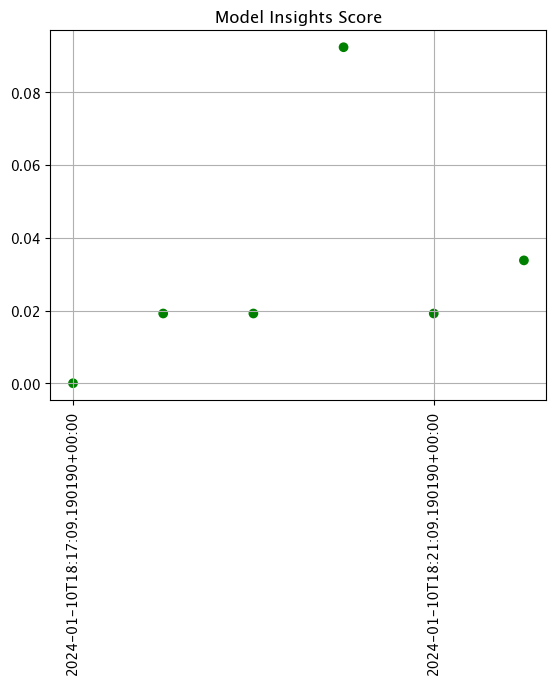

In [42]:
assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()

### Set Observability Data

The next set of inferences will send all blurred image data to the edge deployed pipeline, and all good to the Ops pipeline.  By the end, we will be able to demonstrate viewing the assay results to show detecting the blurred images causing more and more scores outside of the baseline.

Every so often we will rerun the interactive assay to show the updated results.

In [ ]:
assay_window_start = datetime.datetime.now(datetime.timezone.utc)

for i in range(1):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)
for i in range(9):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)


In [44]:
# assay window from dates

assay_window_end = datetime.datetime.now(datetime.timezone.utc)

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)

# View 1 minute intervals
# just combined
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=6)
    .add_interval(minutes=6)
    .add_start(assay_window_start)
    .add_location_filter([ops_partition, edge_name])
)



Generated 1 analyses


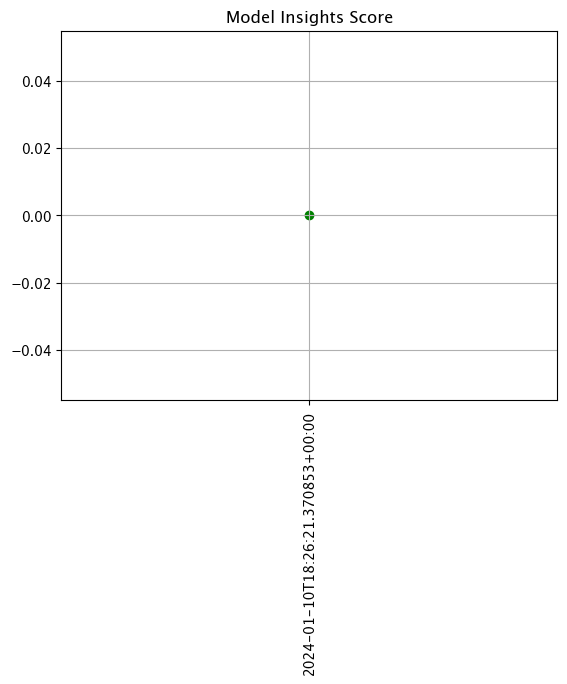

In [45]:
assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()

In [ ]:
for i in range(8):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(2):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

In [ ]:
for i in range(7):
    print(i)
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(3):
    print(i)
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

In [ ]:
for i in range(6):
    print(i)
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(4):
    print(i)
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

In [53]:
# assay window from dates

assay_window_end = datetime.datetime.now(datetime.timezone.utc)

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)




# View 1 minute intervals
# just combined
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=7)
    .add_interval(minutes=7)
    .add_start(assay_window_start)
    .add_location_filter([ops_partition, edge_name])
)



Generated 7 analyses


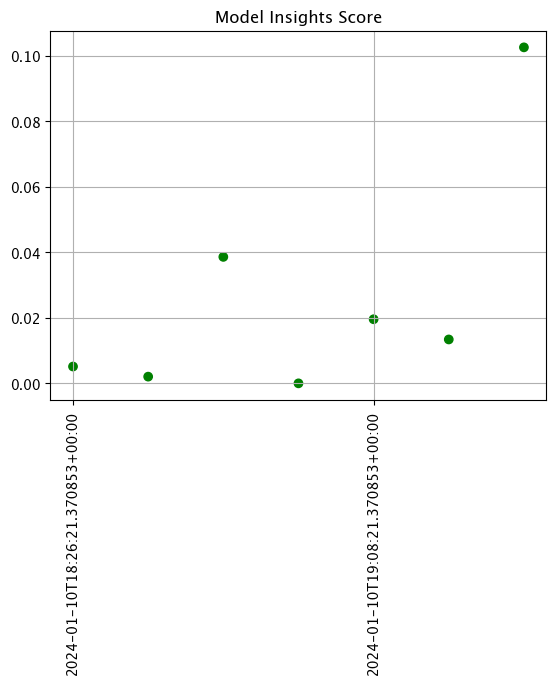

In [54]:
assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()

In [ ]:
for i in range(5):
    print(i)
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(5):
    print(i)
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

In [ ]:
for i in range(4):
    print(i)
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(6):
    print(i)
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

In [ ]:
for i in range(3):
    print(i)
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(7):
    print(i)
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

In [ ]:
for i in range(2):
    print(i)
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(8):
    print(i)
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

In [ ]:
for i in range(1):
    print(i)
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(9):
    print(i)
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

In [ ]:
for i in range(10):
    print(i)
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

In [70]:
# assay window from dates

assay_window_end = datetime.datetime.now(datetime.timezone.utc)

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)



# just combined
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=6)
    .add_interval(minutes=6)
    .add_start(assay_window_start)
    .add_location_filter([ops_partition, edge_name])
)



Generated 16 analyses


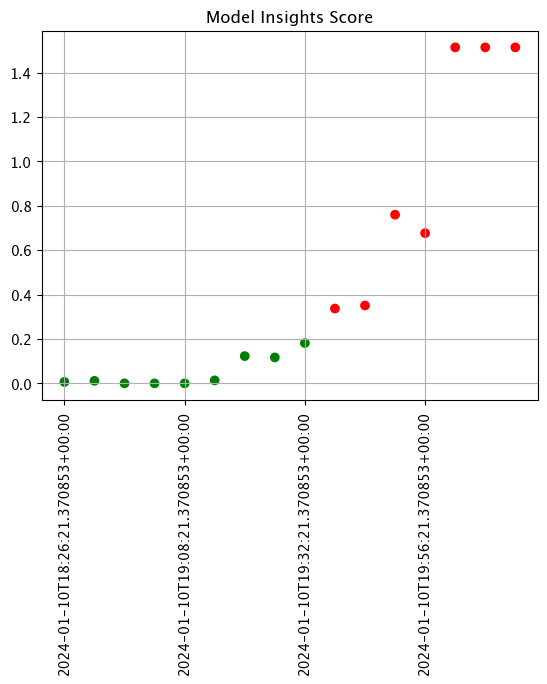

In [71]:
assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()

If we isolate to just the Ops center pipeline, we see a different result.

In [72]:
# assay window from dates

assay_window_end = datetime.datetime.now(datetime.timezone.utc)

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)



# just combined
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=6)
    .add_interval(minutes=6)
    .add_start(assay_window_start)
    .add_location_filter([ops_partition])
)



Generated 13 analyses


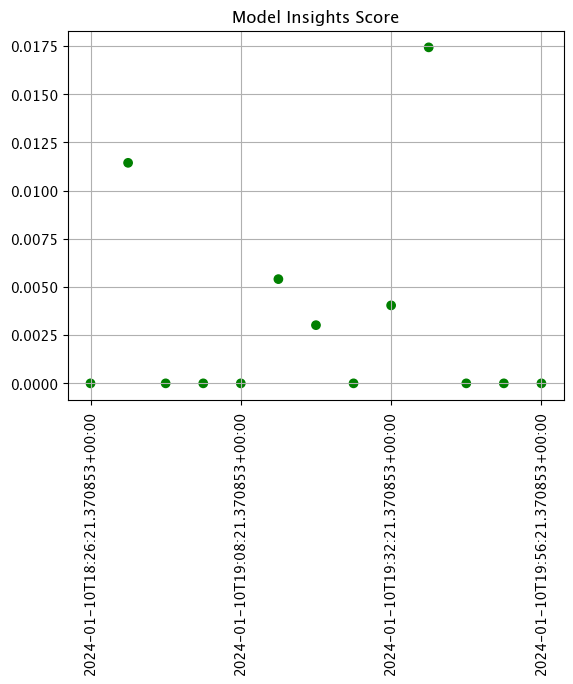

In [73]:
assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()

If we isolate to only the edge location, we see where the out of baseline scores are coming from.

In [74]:
# assay window from dates

assay_window_end = datetime.datetime.now(datetime.timezone.utc)

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)



# just combined
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=6)
    .add_interval(minutes=6)
    .add_start(assay_window_start)
    .add_location_filter([edge_name])
)



Generated 12 analyses


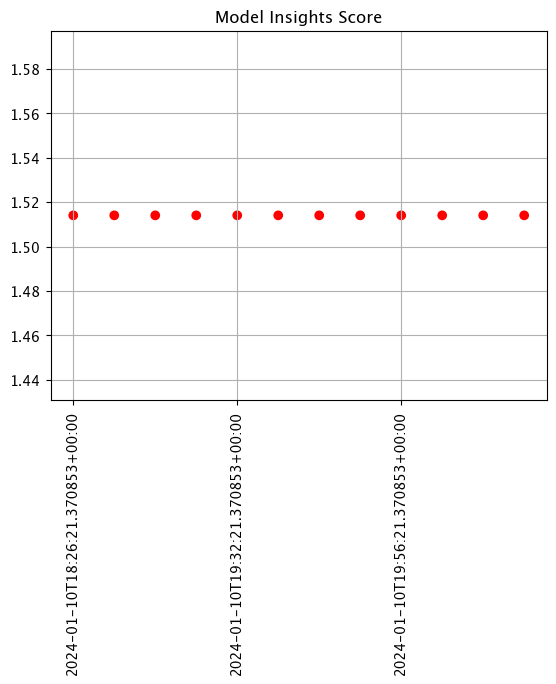

In [75]:
assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()

With the demonstration complete, we can shut down the edge deployed pipeline and undeploy the pipeline in the Ops center.

In [68]:
pipeline.undeploy()

name,retail-inv-tracker-edge-obs
created,2024-01-10 17:50:59.035145+00:00
last_updated,2024-01-10 18:09:22.128239+00:00
deployed,False
arch,None
tags,
versions,"c2dd2c7d-618d-497f-8515-3aa1469d7985, bee8f4f6-b1d3-40e7-9fc5-221db3ff1b87, 79321f4e-ca2d-4be1-8590-8c3be5d8953c, 64c06b04-d8fb-4651-ae5e-886c12a30e94, d0c2ed1c-3691-49f1-8fc8-e6510e4c39f8, 773099d3-6d64-4a92-b5a7-f614a916965d"
steps,resnet-with-intensity
published,True
